## **#1 Import Libraries**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report

import numpy as np

In [ ]:
# pandas data frame options tweaking.
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


## **#2 Load Dataset**

In [ ]:
dataset_url = 'https://raw.githubusercontent.com/M-Zouman/GP2/main/Datasets/Laboratory%20Based/Albert%20Einstein%20Hospital%2C%20Brazil%20Dataset/Metadata/Dataset(A).csv'
data = pd.read_csv(dataset_url, encoding = "utf-8")

## **#3 Preprocessing**

In [ ]:
# Target variable class distribution of [orginal dataset].
print(data.groupby('SARS-Cov-2 exam result').size())

SARS-Cov-2 exam result
negative    5086
positive     558
dtype: int64


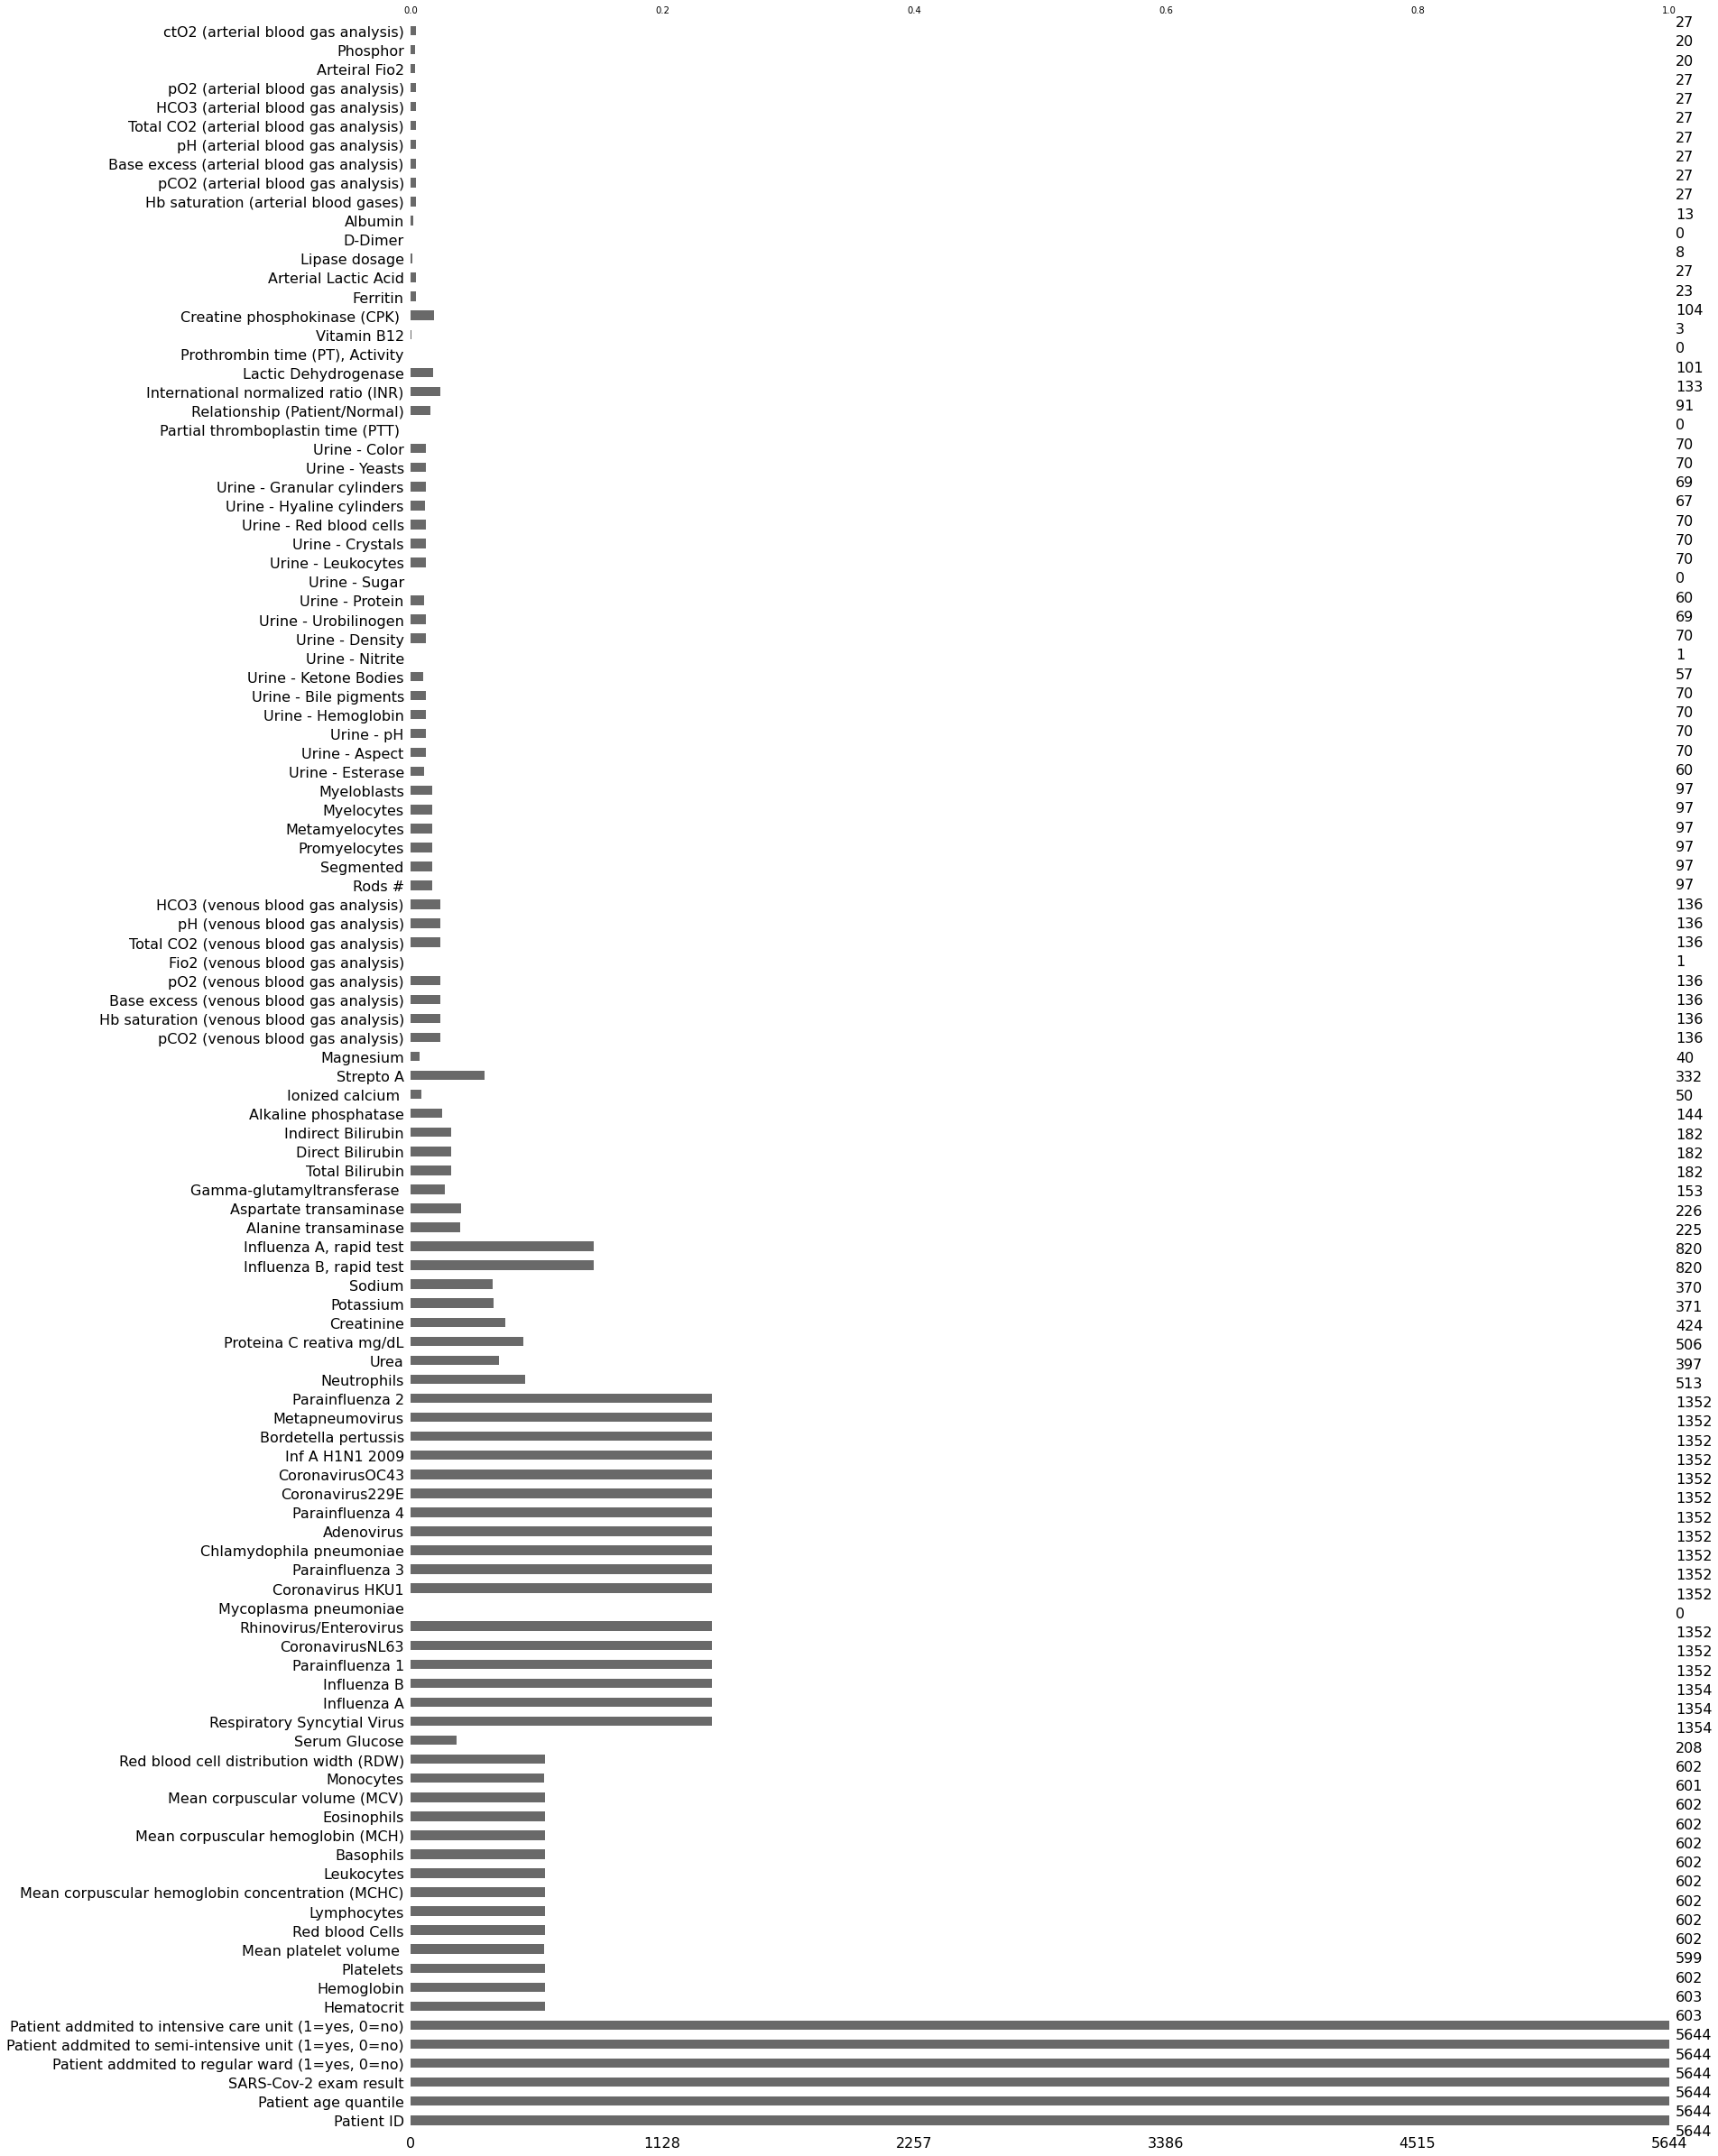

In [ ]:
# Bar chart of the number of values each feature has. [Orginal Dataset]
msno.bar(data)

In [ ]:
# Shrinking dataset.
print('Dataset shape [before] shrinking: ', data.shape) # Dataset dimensions. (BEFORE)

# Using the feature 'Parainfluenza 1' to shrink the dataset by deleting the samples that has a null vlaue for this column.
data.dropna(subset = ['Parainfluenza 1'], inplace=True)
data.reset_index(drop=True, inplace=True)

print('Dataset shape [after] shrinking: ', data.shape) # Dataset dimensions. (AFTER)

Dataset shape [before] shrinking:  (5644, 111)
Dataset shape [after] shrinking:  (1352, 111)


In [ ]:
# Target variable class distribution of [shrinked dataset].
data.groupby('SARS-Cov-2 exam result').size()

SARS-Cov-2 exam result
negative    1240
positive     112
dtype: int64

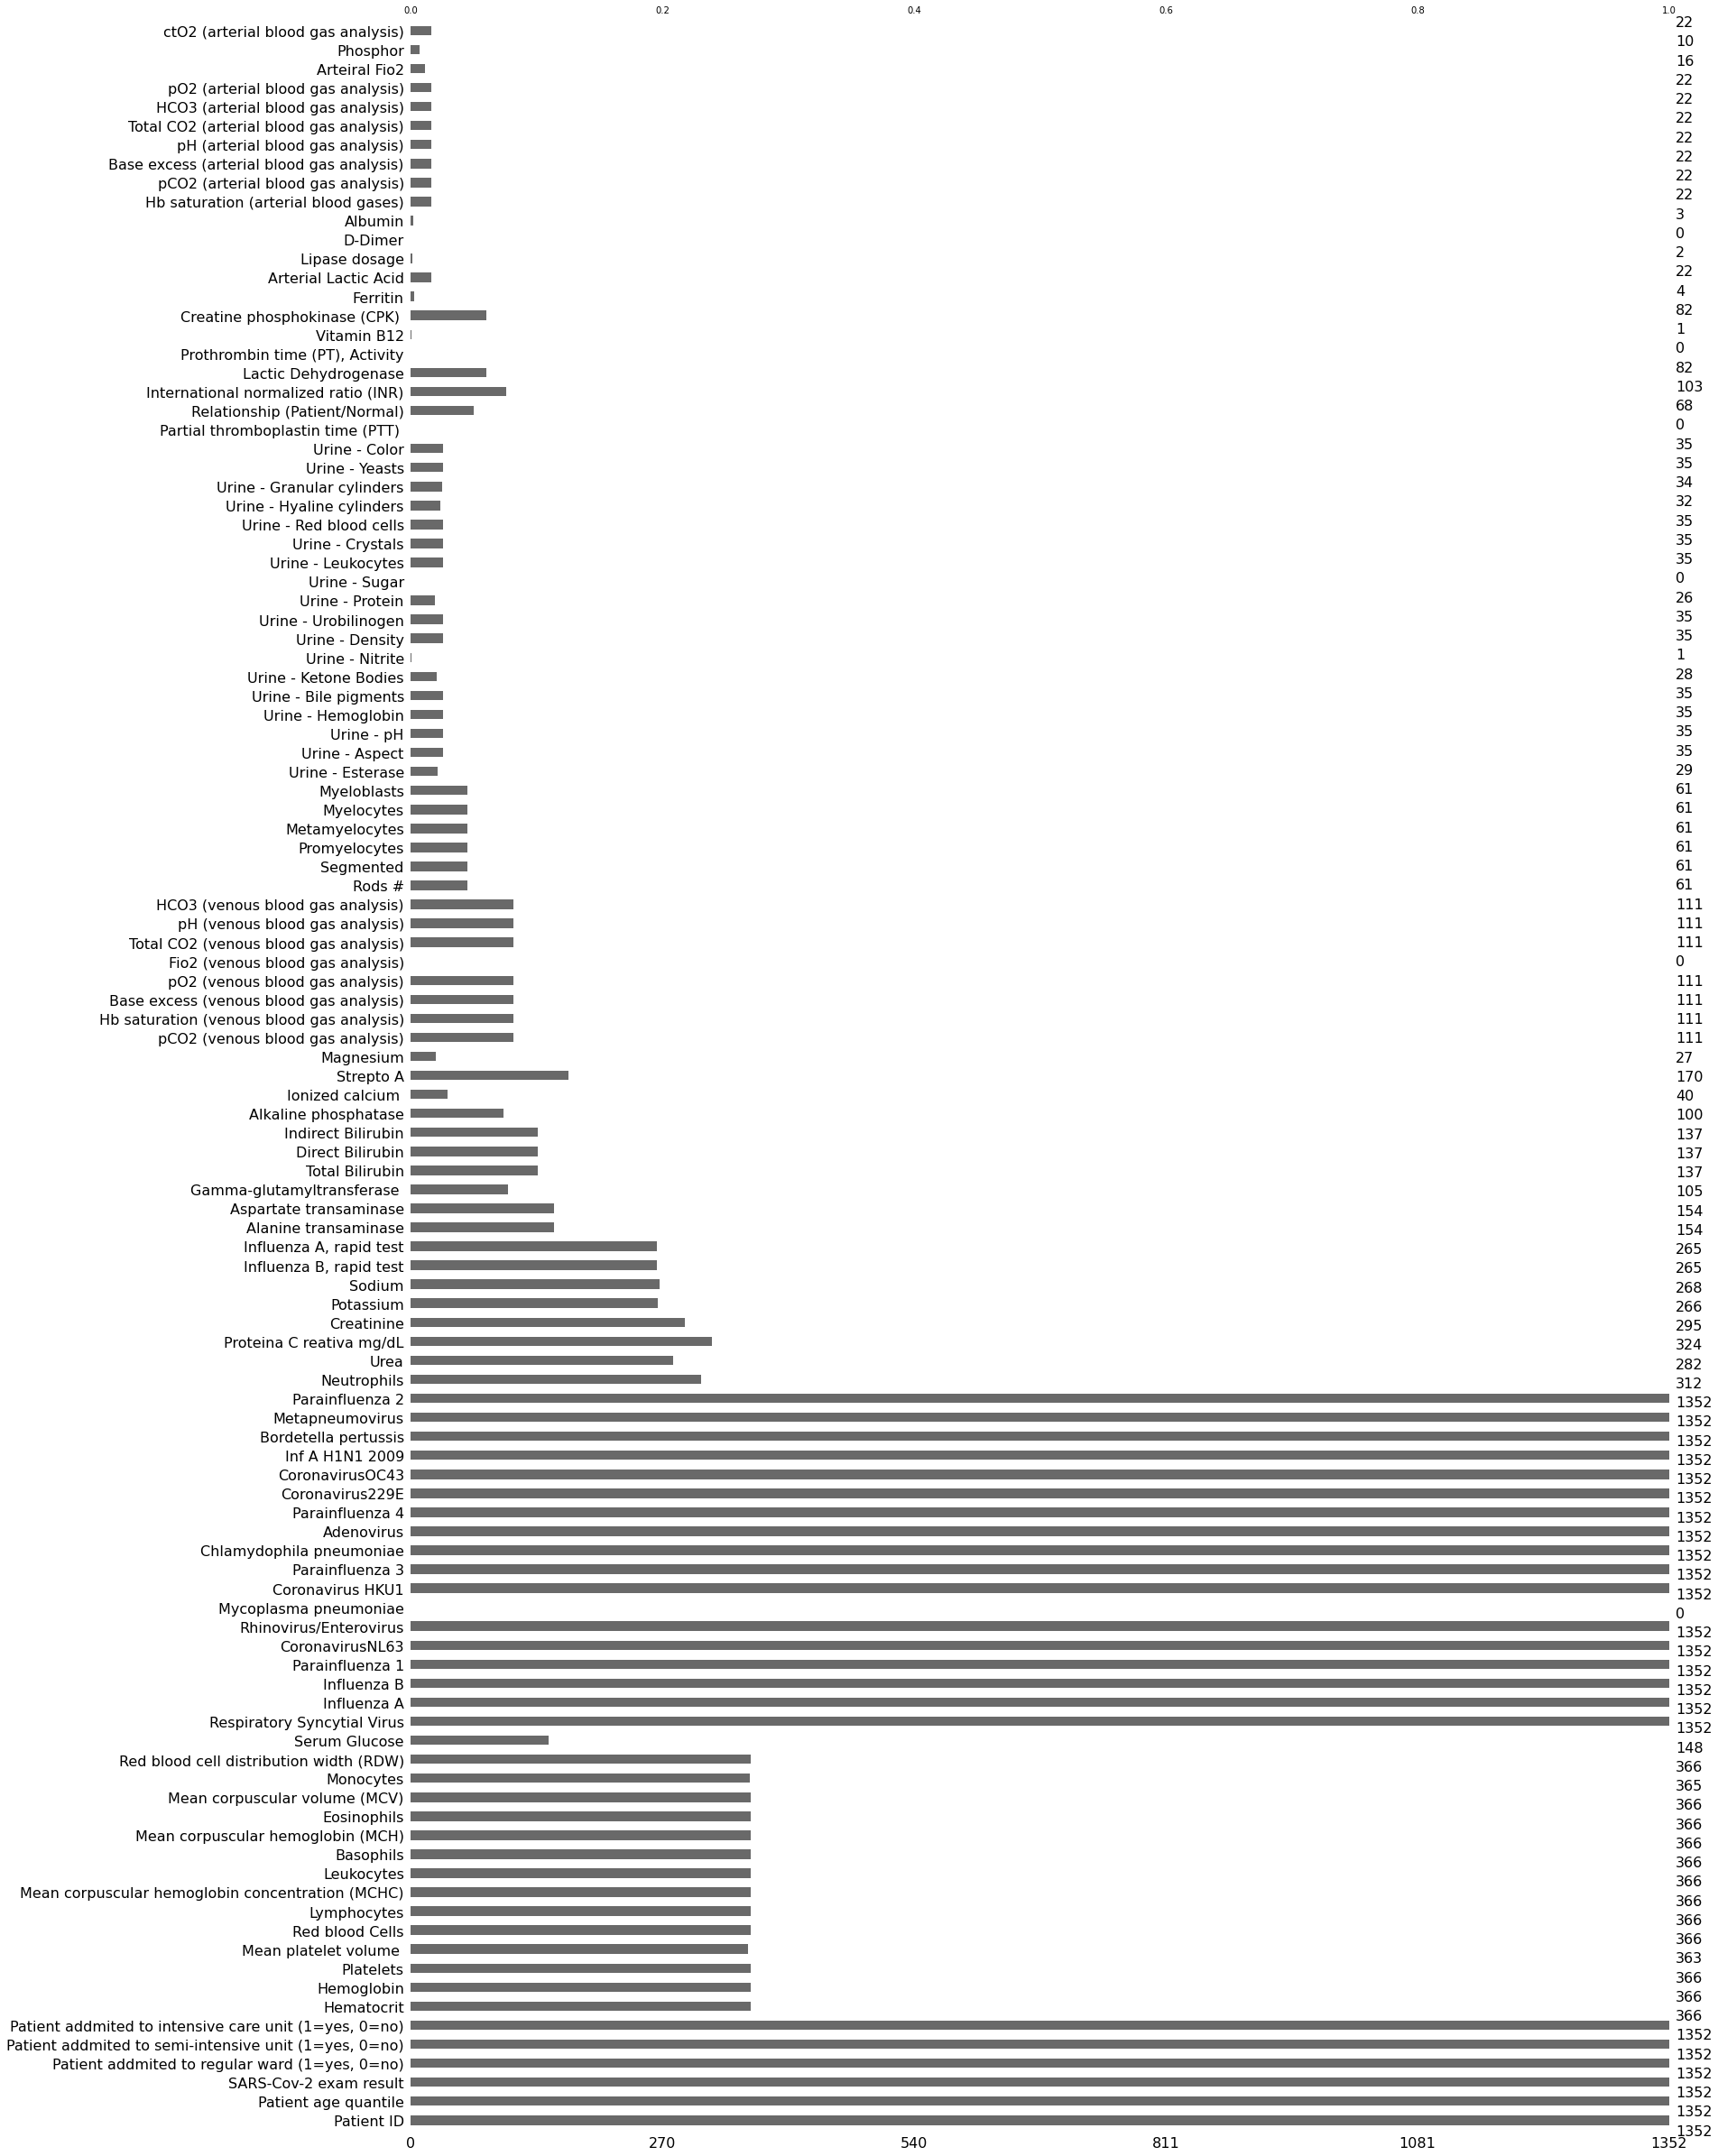

In [ ]:
# Bar chart of the number of values each feature has. [Shrinked Dataset]
msno.bar(data)

In [ ]:
# Split the data into X = independent variables, y = depndent variable.
X = data.drop(['Patient ID', 
               'SARS-Cov-2 exam result', 
               'Patient addmited to regular ward (1=yes, 0=no)', 
               'Patient addmited to semi-intensive unit (1=yes, 0=no)', 
               'Patient addmited to intensive care unit (1=yes, 0=no)'], 
               axis=1)
y = data['SARS-Cov-2 exam result']

In [ ]:
# Identify categorical features and numeric features in seprate lists then combine them in one list.
categorical_features = ['Respiratory Syncytial Virus', 
                        'Influenza A', 
                        'Influenza B', 
                        'Parainfluenza 1',
                        'CoronavirusNL63', 
                        'Rhinovirus/Enterovirus', 
                        'Coronavirus HKU1', 
                        'Parainfluenza 3', 
                        'Chlamydophila pneumoniae', 
                        'Adenovirus', 
                        'Parainfluenza 4', 
                        'Coronavirus229E', 
                        'CoronavirusOC43', 
                        'Inf A H1N1 2009', 
                        'Bordetella pertussis', 
                        'Metapneumovirus', 
                        'Parainfluenza 2', 
                        'Influenza B, rapid test', 
                        'Influenza A, rapid test', 
                        'Strepto A', 
                        'Urine - Esterase', 
                        'Urine - Aspect', 
                        'Urine - pH', 
                        'Urine - Hemoglobin', 
                        'Urine - Bile pigments', 
                        'Urine - Ketone Bodies', 
                        'Urine - Nitrite', 
                        'Urine - Urobilinogen', 
                        'Urine - Protein', 
                        'Urine - Leukocytes', 
                        'Urine - Crystals', 
                        'Urine - Hyaline cylinders', 
                        'Urine - Granular cylinders', 
                        'Urine - Yeasts', 
                        'Urine - Color'] #36

numerical_features = []
counter = 0
for column in X:
  counter = 0
  for i in range(len(categorical_features)):
    if column == categorical_features[i]:
      counter = 1

  if counter == 0:
    numerical_features.append(column)

cat_num_features = []
for i in range(len(categorical_features)):
  cat_num_features.append(categorical_features[i])

for i in range(len(numerical_features)):
  cat_num_features.append(numerical_features[i])

# Verify both has same number of features.
print("Shape of X:", X.shape)
print("Number of Categorical Features =", len(categorical_features))
print("Number of Numerical Features =", len(numerical_features))

Shape of X: (1352, 106)
Number of Categorical Features = 35
Number of Numerical Features = 71


In [ ]:
# Show the percentage of missing vlaues for each feature.
X.isna().mean().round(4) * 100

Patient age quantile                                  0.00
Hematocrit                                           72.93
Hemoglobin                                           72.93
Platelets                                            72.93
Mean platelet volume                                 73.15
Red blood Cells                                      72.93
Lymphocytes                                          72.93
Mean corpuscular hemoglobin concentration (MCHC)     72.93
Leukocytes                                           72.93
Basophils                                            72.93
Mean corpuscular hemoglobin (MCH)                    72.93
Eosinophils                                          72.93
Mean corpuscular volume (MCV)                        72.93
Monocytes                                            73.00
Red blood cell distribution width (RDW)              72.93
Serum Glucose                                        89.05
Respiratory Syncytial Virus                           0.

In [ ]:
# Drop features with more than 75% of missing values.
count = 0
for column in X.columns:
  if(X[column].isna().mean().round(4) * 100 > 75.00):
    count += 1
    if(X[column].dtype == 'object'):
      categorical_features.remove(column)
    else:
      numerical_features.remove(column)

    cat_num_features.remove(column)
    X.drop(column, axis=1, inplace=True) 
    
print('The number of features with 75% or more missing values is: ', count)

The number of features with 75% or more missing values is:  74


In [ ]:
# Show the percentage of missing vlaues for each feature after dropping. 
X.isna().mean().round(4) * 100

Patient age quantile                                 0.00
Hematocrit                                          72.93
Hemoglobin                                          72.93
Platelets                                           72.93
Mean platelet volume                                73.15
Red blood Cells                                     72.93
Lymphocytes                                         72.93
Mean corpuscular hemoglobin concentration (MCHC)    72.93
Leukocytes                                          72.93
Basophils                                           72.93
Mean corpuscular hemoglobin (MCH)                   72.93
Eosinophils                                         72.93
Mean corpuscular volume (MCV)                       72.93
Monocytes                                           73.00
Red blood cell distribution width (RDW)             72.93
Respiratory Syncytial Virus                          0.00
Influenza A                                          0.00
Influenza B   

In [ ]:
# Drop features with only 1 unique value (Zero Variance Features).
print(X.nunique())
X.drop('Parainfluenza 2', axis=1, inplace=True)
categorical_features.remove('Parainfluenza 2')
cat_num_features.remove('Parainfluenza 2')
print("Shape of X: ", X.shape)

Patient age quantile                                 20
Hematocrit                                          152
Hemoglobin                                           77
Platelets                                           198
Mean platelet volume                                 44
Red blood Cells                                     180
Lymphocytes                                         236
Mean corpuscular hemoglobin concentration (MCHC)     55
Leukocytes                                          314
Basophils                                            16
Mean corpuscular hemoglobin (MCH)                    81
Eosinophils                                          73
Mean corpuscular volume (MCV)                       159
Monocytes                                           125
Red blood cell distribution width (RDW)              54
Respiratory Syncytial Virus                           2
Influenza A                                           2
Influenza B                                     

In [ ]:
# Transform categorical features into numeric & Impute missing vlaues [KNN IMPUTER].
print("Shape of X [before] categorical features trasformation: ", X.shape)

dummies = pd.get_dummies(X[categorical_features], drop_first=False)

X.drop(categorical_features, axis=1, inplace=True)
imputer = KNNImputer(n_neighbors=37)
filled_X = imputer.fit_transform(X)
X = pd.DataFrame(filled_X, columns=numerical_features)

X = X.join(dummies)

print("Shape of X [after] categorical features trasformation: ", X.shape)

Shape of X [before] categorical features trasformation:  (1352, 31)
Shape of X [after] categorical features trasformation:  (1352, 47)


In [ ]:
# Standraize features.
feature_names = []
for column in X.columns:
  feature_names.append(column)

standardize_scaler = StandardScaler()

standardizedX = standardize_scaler.fit(X).transform(X)
X = pd.DataFrame(standardizedX, columns=feature_names)

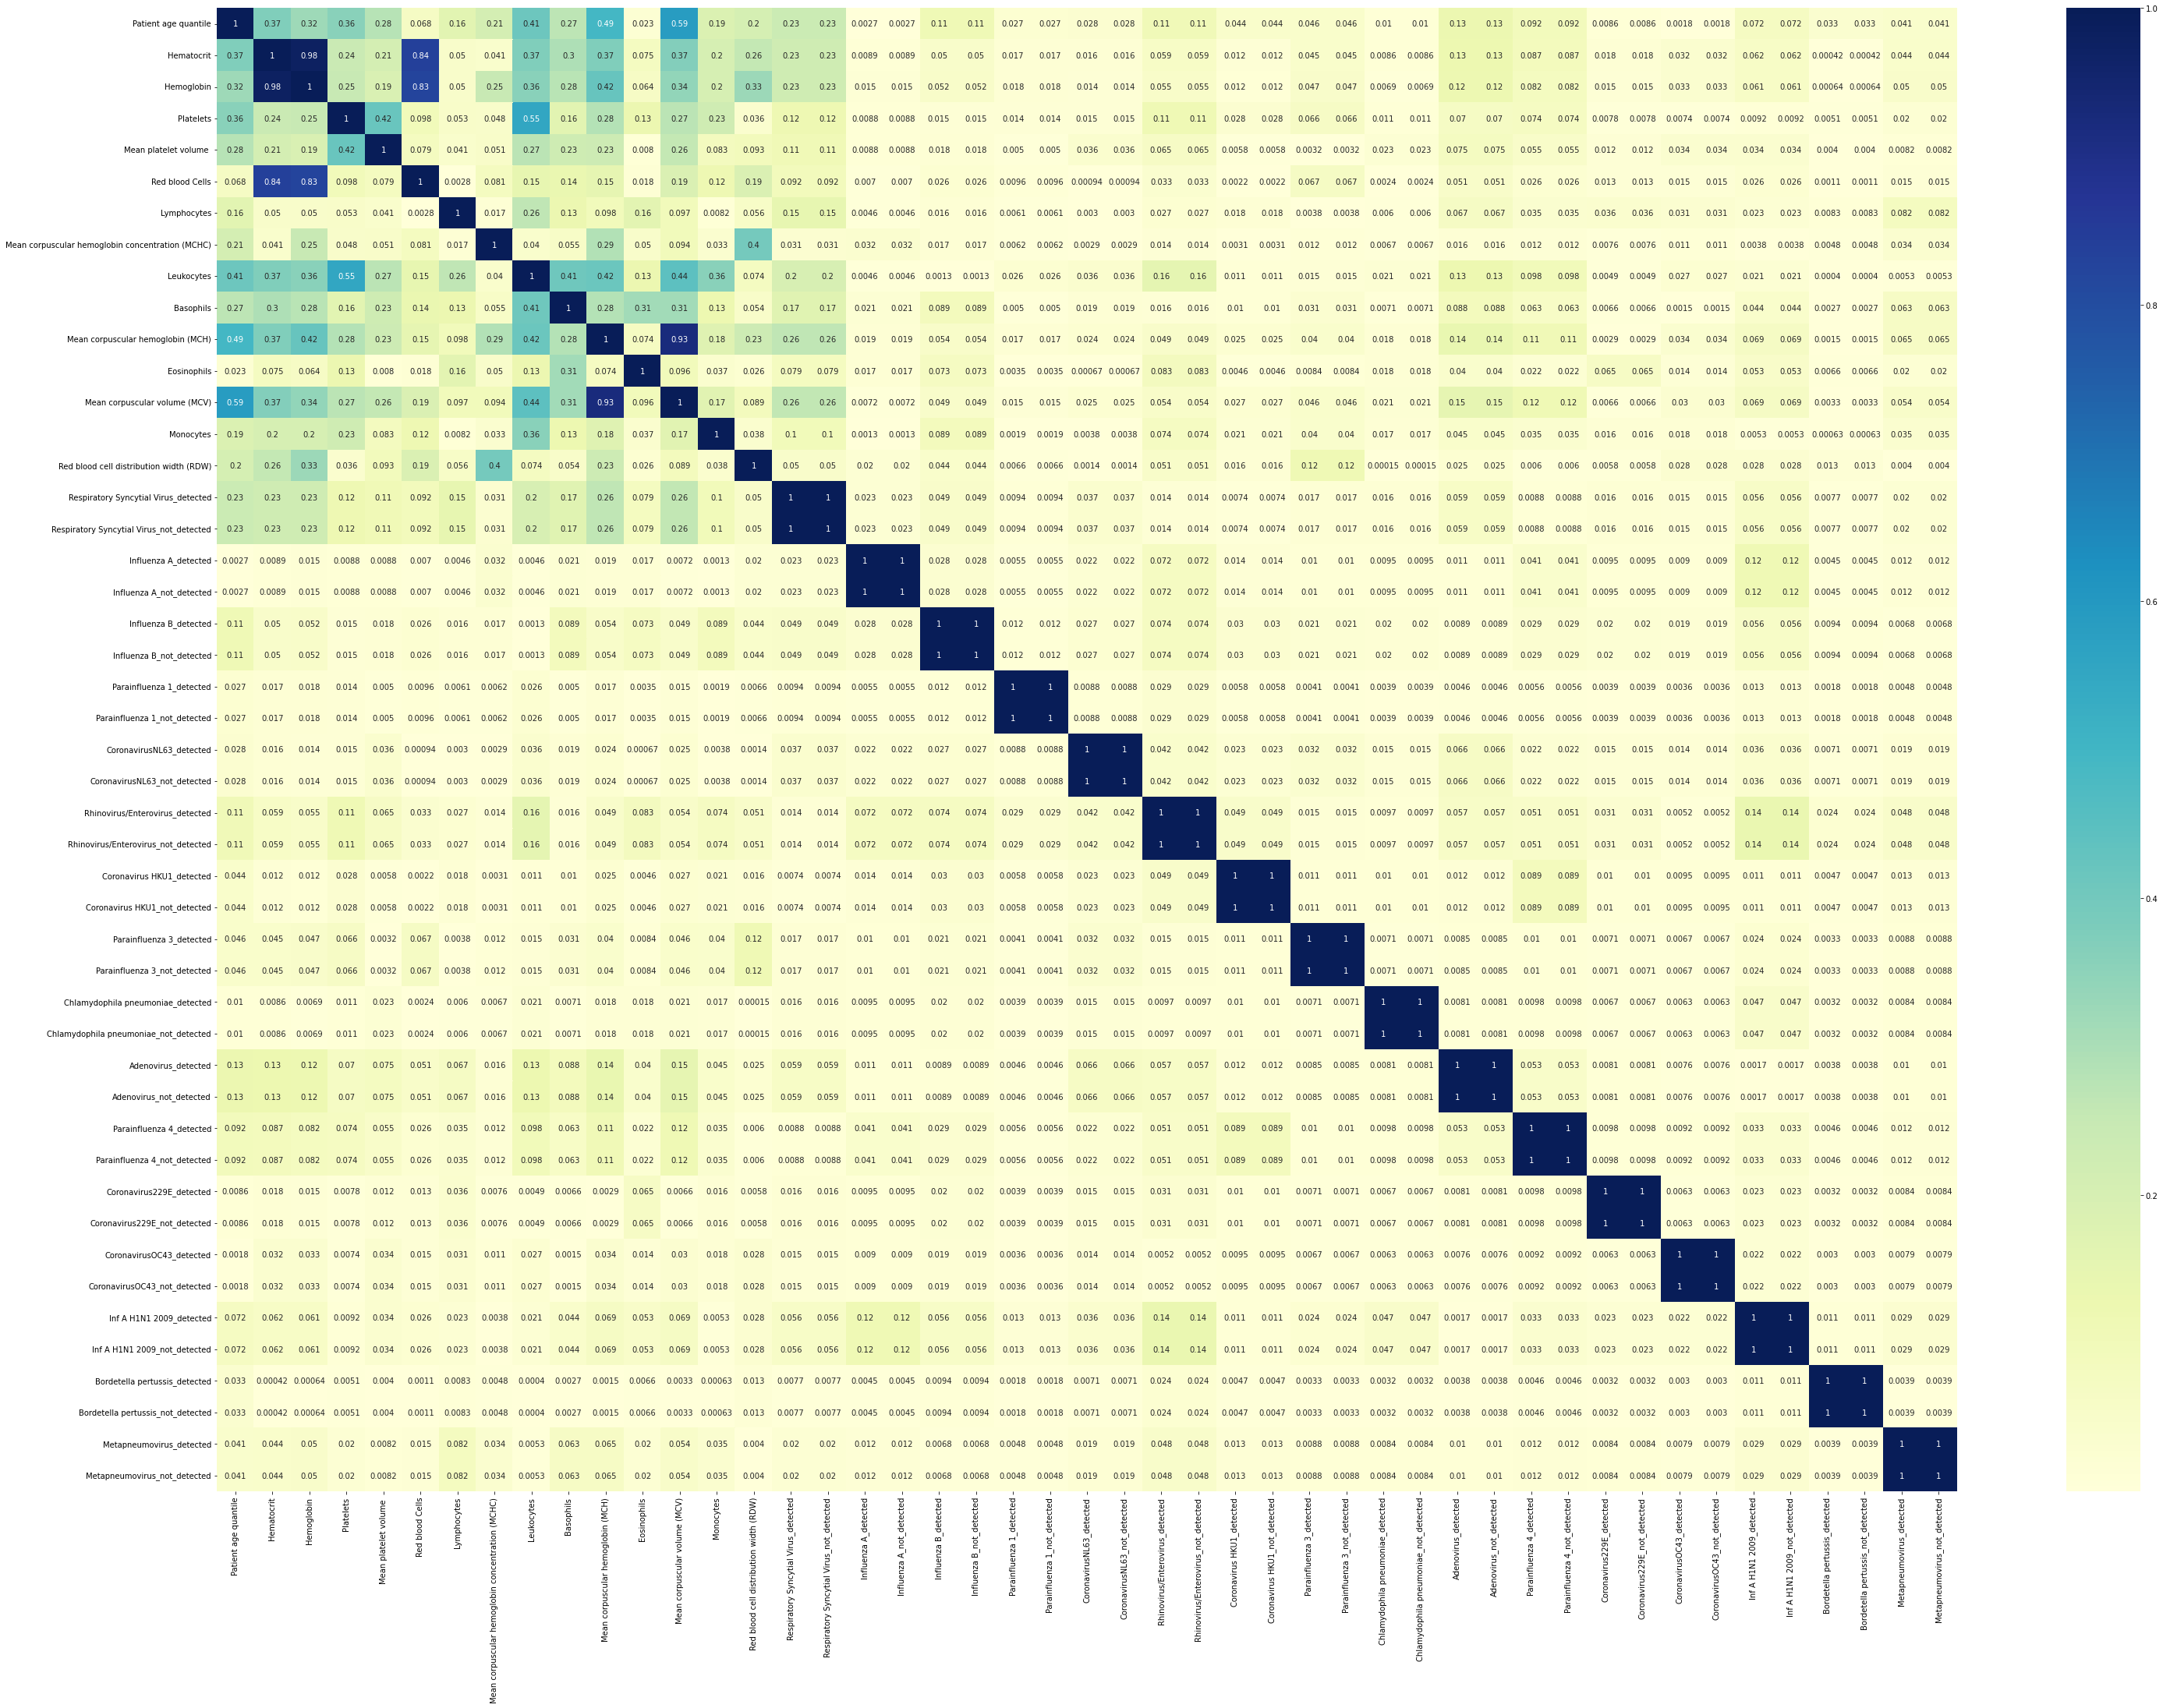

In [ ]:
# correlation matrix to see if there are features with high correlation.
plt.figure(figsize = (50,35))
corr = X.corr().abs()
hm = sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.show()

In [ ]:
# From a pair of features drop one of them if they have 90% or above correlation.
X.drop(["Hemoglobin"], axis=1, inplace=True) # Hematocrit and Hemoglobin have 97% correlation, and since Hematocrit has higher feature importance score, Hemoglobin is dropped.
feature_names.remove('Hemoglobin')

In [ ]:
print("Shape of the dataset [before] preprocessing: (5644, 111)")
print("Shape of the dataset [after] preprocessing: (1352, 47)")

Shape of the dataset [before] preprocessing: (5644, 111)
Shape of the dataset [after] preprocessing: (1352, 47)


## **#4 Model**

In [ ]:
# Target variable class distribution.
print(pd.DataFrame(y).groupby('SARS-Cov-2 exam result').size())

SARS-Cov-2 exam result
negative    1240
positive     112
dtype: int64


In [ ]:
# List of all 7 classifiers.
model_list = [LogisticRegression(random_state=111), svm.SVC(random_state=111), KNeighborsClassifier(n_neighbors=37), 
              GaussianNB(), DecisionTreeClassifier(random_state=111), RandomForestClassifier(random_state=111), 
              xgb.XGBClassifier(random_state=111)]

model_names_list = ['LR', 'SVM', 'KNN', 'NB', 'DT', 'RF', 'XGB']

### Spliting the Dataset into 10 splits.

In [ ]:
data = X.join(y)

# Seprate Positive and Negative cases.
data_pos = data[data['SARS-Cov-2 exam result'].str.contains('positive')].reset_index(drop=True)
data_neg = data[data['SARS-Cov-2 exam result'].str.contains('negative')].reset_index(drop=True)

# Divide the data into 11 pieces of the same 112 postive and different 112 negative cases.
data1 = pd.concat([data_neg.iloc[0:112, :], data_pos]).sample(frac=1, random_state=111).reset_index(drop=True)
data2 = pd.concat([data_neg.iloc[112:224, :], data_pos]).sample(frac=1, random_state=111).reset_index(drop=True)
data3 = pd.concat([data_neg.iloc[224:336, :], data_pos]).sample(frac=1, random_state=111).reset_index(drop=True)
data4 = pd.concat([data_neg.iloc[336:448, :], data_pos]).sample(frac=1, random_state=111).reset_index(drop=True)
data5 = pd.concat([data_neg.iloc[448:560, :], data_pos]).sample(frac=1, random_state=111).reset_index(drop=True)
data6 = pd.concat([data_neg.iloc[560:672, :], data_pos]).sample(frac=1, random_state=111).reset_index(drop=True)
data7 = pd.concat([data_neg.iloc[672:784, :], data_pos]).sample(frac=1, random_state=111).reset_index(drop=True)
data8 = pd.concat([data_neg.iloc[784:896, :], data_pos]).sample(frac=1, random_state=111).reset_index(drop=True)
data9 = pd.concat([data_neg.iloc[896:1008, :], data_pos]).sample(frac=1, random_state=111).reset_index(drop=True)
data10 = pd.concat([data_neg.iloc[1008:1120, :], data_pos]).sample(frac=1, random_state=111).reset_index(drop=True)
data11 = pd.concat([data_neg.iloc[1120:1232, :], data_pos]).sample(frac=1, random_state=111).reset_index(drop=True)

# Collect all 11 splits of the dataset in a list.
data_list = [data1, data2, data3, data4, data5, data6, data7, data8, data9, data10, data11]

In [ ]:
# Models evaluation using 5-fold cross validation.
cross_validator = ShuffleSplit(n_splits=5, random_state=111)

score_f1_list = []
score_recall_list = []
score_precision_list = []
for m in range(len(model_list)):
  model = model_list[m]
  average_of_splits_f1 = []
  average_of_splits_recall = []
  average_of_splits_precision = []
  for i in range(len(data_list)):
    # Split the data.
    data_X = data_list[i].drop('SARS-Cov-2 exam result', axis=1)
    data_y = data_list[i]['SARS-Cov-2 exam result']
  
    # Cross Valdation
    score_f1 = cross_val_score(model, data_X, data_y, scoring='f1_macro', cv=cross_validator).mean().round(2)
    average_of_splits_f1.append(score_f1)

    score_recall = cross_val_score(model, data_X, data_y, scoring='recall_macro', cv=cross_validator).mean().round(2)
    average_of_splits_recall.append(score_recall)

    score_precision = cross_val_score(model, data_X, data_y, scoring='precision_macro', cv=cross_validator).mean().round(2)
    average_of_splits_precision.append(score_precision)

  print("The average [F1-Score] of all data splits using {} classifier, is: {}".format(model_names_list[m], np.array(average_of_splits_f1).mean().round(2) * 100))
  score_f1_list.append(np.array(average_of_splits_f1).mean().round(2) * 100)
  print("The average [Recall-Score] of all data splits using {} classifier, is: {}".format(model_names_list[m], np.array(average_of_splits_recall).mean().round(2) * 100))
  score_recall_list.append(np.array(average_of_splits_recall).mean().round(2) * 100)
  print("The average [Precision-Score] of all data splits using {} classifier, is: {}".format(model_names_list[m], np.array(average_of_splits_precision).mean().round(2) * 100))
  score_precision_list.append(np.array(average_of_splits_precision).mean().round(2) * 100)
  print()

The average [F1-Score] of all data splits using LR classifier, is: 75.0
The average [Recall-Score] of all data splits using LR classifier, is: 76.0
The average [Precision-Score] of all data splits using LR classifier, is: 79.0

The average [F1-Score] of all data splits using SVM classifier, is: 77.0
The average [Recall-Score] of all data splits using SVM classifier, is: 77.0
The average [Precision-Score] of all data splits using SVM classifier, is: 81.0

The average [F1-Score] of all data splits using KNN classifier, is: 73.0
The average [Recall-Score] of all data splits using KNN classifier, is: 74.0
The average [Precision-Score] of all data splits using KNN classifier, is: 76.0

The average [F1-Score] of all data splits using NB classifier, is: 53.0
The average [Recall-Score] of all data splits using NB classifier, is: 60.0
The average [Precision-Score] of all data splits using NB classifier, is: 76.0

The average [F1-Score] of all data splits using DT classifier, is: 71.0
The averag

In [ ]:
# Results visualization. [F1-score]
ax = sns.barplot(x=model_names_list, y=score_f1_list)
plt.xlabel('Models', fontsize = 20)
plt.ylabel('% of F1-score', fontsize = 20)
plt.title('F1-score of the Models', fontsize = 20)

for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    xs, ys = i.get_xy() 
    ax.annotate(f'{round(height,2)}%', (xs + width/2, ys + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

In [ ]:
# Results visualization. [Recall]
ax = sns.barplot(x=model_names_list, y=score_recall_list) 
plt.xlabel('Models', fontsize = 20)
plt.ylabel('% of Recall', fontsize = 20)
plt.title('Recall of the Models', fontsize = 20)

for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    xs, ys = i.get_xy() 
    ax.annotate(f'{round(height,2)}%', (xs + width/2, ys + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

In [ ]:
# Results visualization. [Precision]
ax = sns.barplot(x=model_names_list, y=score_precision_list) 
plt.xlabel('Models', fontsize = 20)
plt.ylabel('% of Precision', fontsize = 20)
plt.title('Precision of the Models', fontsize = 20)

for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    xs, ys = i.get_xy() 
    ax.annotate(f'{round(height,2)}%', (xs + width/2, ys + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

## **#5 Feature Importance**

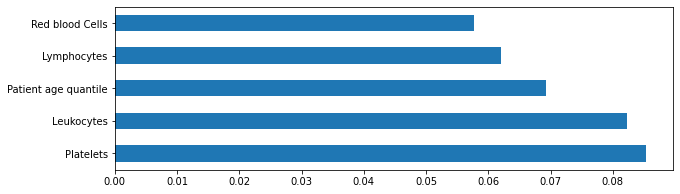

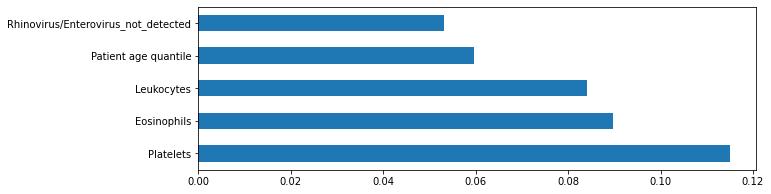

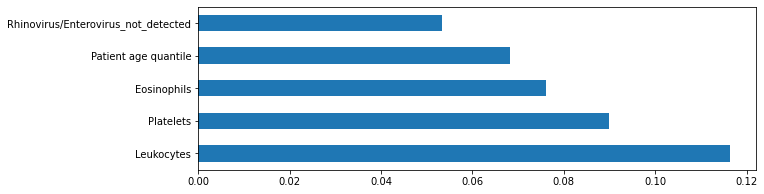

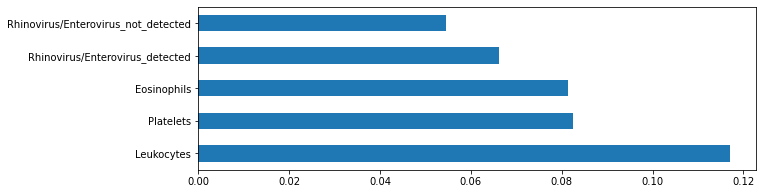

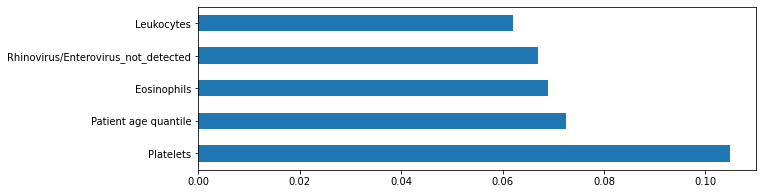

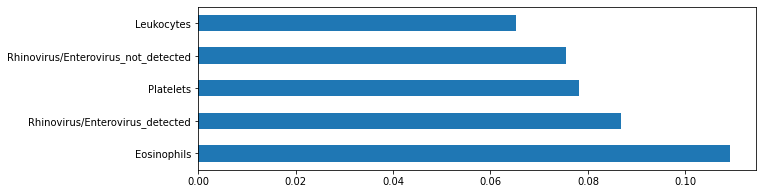

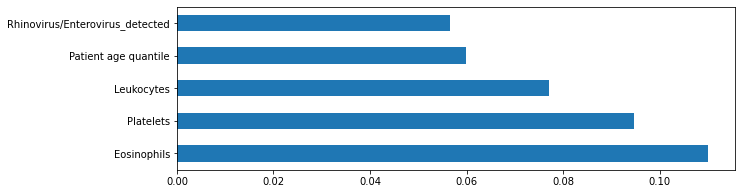

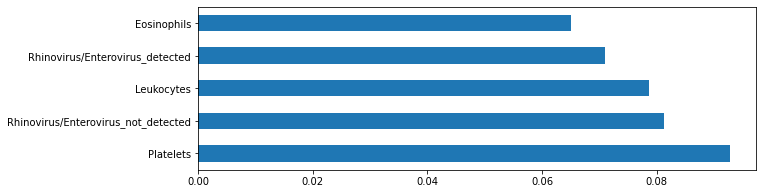

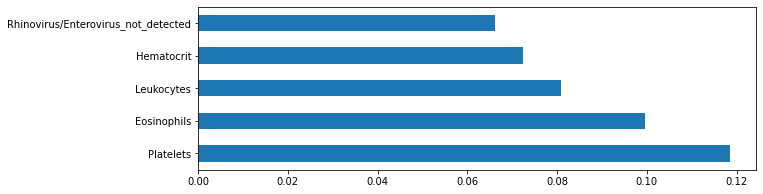

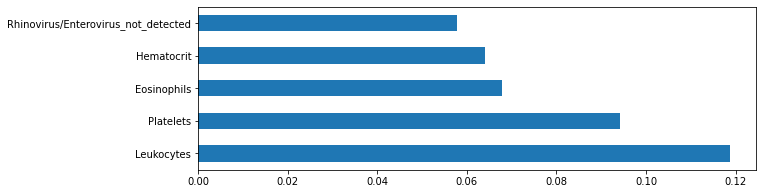

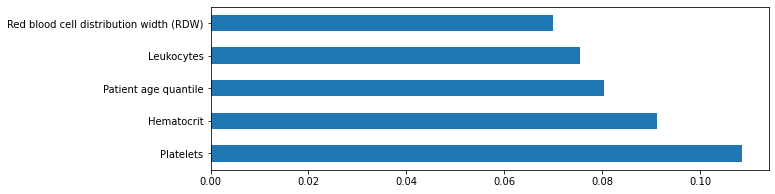

In [ ]:
# Feature importance using RF.
model = RandomForestClassifier(random_state=111)
for i in range(len(data_list)):
    # Split the data.
    data_X = data_list[i].drop('SARS-Cov-2 exam result', axis=1)
    data_y = data_list[i]['SARS-Cov-2 exam result']

    model.fit(data_X, data_y)

    features_importance = pd.Series(model.feature_importances_, index=data_X.columns)

    # Show the top 5 most important features.
    features_importance.nlargest(5).plot(figsize=(10, 3), kind='barh')
    plt.show()